In [68]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [76]:
data = pd.read_csv('sdwpf134_initial_kddcup.csv')
# 去除每台机器最后27个数据
# data = data.drop(data.groupby('TurbID').tail(27).index)

In [70]:
# 获取一周的时间index 1-672
def get_time_week(data):
    tmp = []
    timelength = data['Tmstamp'].nunique()*data['Day'].nunique()
    for i in range(data['TurbID'].nunique()):
        tmp  = tmp + list(range(timelength))
    data['time_week'] = tmp
    
    return data

In [71]:
# 获取一天的时间index 0，15，30...

def get_time_day(data):
    tmp = []
    timelength = data['Tmstamp'].nunique()*data['Day'].nunique()
    tmstamp = data['Tmstamp'][:timelength].tolist()
    tmstamp_num = []
    for i in tmstamp:
        tmstamp_num.append(int(i[:2])*60+int(i[3:]))
    for i in range(data['TurbID'].nunique()):
        tmp  = tmp + tmstamp_num
    data['time_day'] = tmp
    
    return data

In [75]:
# 获取一天的hour...

def get_time_hour(data):
    tmp = []
    timelength = data['Tmstamp'].nunique()*data['Day'].nunique()
    tmstamp = data['Tmstamp'][:timelength].tolist()
    tmstamp_num = []
    for i in tmstamp:
        tmstamp_num.append(int((int(i[:2])*60+int(i[3:]))/60))
    for i in range(data['TurbID'].nunique()):
        tmp  = tmp + tmstamp_num
    data['time_hour'] = tmp
    
    return data

In [5]:
# 时间的三角函数处理，与归一化选一个使用

def time_triangle(data):
    time = []
    for i in range(len(data.Tmstamp)):
        time.append(datetime.datetime.strptime(data.Tmstamp[i],'%M:%S'))
    data['timestamp'] = time
    timestamp_s = data['timestamp'].map(datetime.datetime.timestamp)
    day = 24*60*60
    data['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    data['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    
    return data

In [6]:
# 归一化
def normalization(data):
    scaler = lambda x : (x-np.min(x)) / (np.max(x)-np.min(x))
    
    # (-1,1)
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler_a1 = MinMaxScaler(feature_range=(0, 1)).fit(pf[["attribute1"]])
    data = pd.DataFrame(scaler.fit_transform(data),
                                 columns = data.columns.values,
                                index = data.index)
    
    return data
    # data.time_week = data[['time_week']].apply(scaler)
    # data.time_day = data[['time_day']].apply(scaler)

In [7]:
# 异常值处理-温度替换-龙哥

def tmp_anomaly_replace(data):
    data['Etmp'] = data['Etmp'].replace(-272,np.nan)
    data['Etmp'] = data['Etmp'].fillna(method='ffill')
    data['Itmp'] = data['Itmp'].replace(-273.2,np.nan)
    data['Itmp'] = data['Itmp'].fillna(method='ffill')
    
    return data

In [8]:
# 异常值处理-外部温度-3σ

def Etmp_anomaly_process(data):
    normal_etmp = data[(data["Etmp"] >= -50) & (data["Etmp"] <= 50)]["Etmp"]

    # 定义3σ原则表达式
    min_mask = data["Etmp"] < (normal_etmp.mean() - 3 * normal_etmp.std())
    max_mask = data["Etmp"] > (normal_etmp.mean() + 3 * normal_etmp.std())

    # 只要满足上诉表达式的任一个就为异常值，所以这里使用位与运算
    mask = min_mask | max_mask

    data.loc[mask,"Etmp"] = normal_etmp.mean()
    
    return data

In [9]:
# 异常值处理-内部温度-3σ

def Itmp_anomaly_process(data):
    normal_itmp = data[(data["Itmp"] > 0) & (data["Itmp"] <= 50)]["Itmp"]

    # 定义3σ原则表达式
    min_mask = data["Itmp"] < (normal_itmp.mean() - 3 * normal_itmp.std())
    max_mask = data["Itmp"] > (normal_itmp.mean() + 3 * normal_itmp.std())

    # 只要满足上诉表达式的任一个就为异常值，所以这里使用位与运算
    mask = min_mask | max_mask

    data.loc[mask,"Itmp"] = normal_itmp.mean()
    
    return data

In [65]:
# 峰值
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

# 输入需要找峰值的列名列表，如['Wspd','Wdir']
# 返回每列的峰值列表[[],[]]
def raw_data_peak(data, li, distance=1):
    peak_list = []
    for i in range(len(li)):
        x = data[li[i]].values
        peaks, _ = find_peaks(x, height=0, distance=distance)
        plt.plot(x)
        plt.plot(peaks, x[peaks], "x")
        plt.plot(np.zeros_like(x), "--", color="gray")
        plt.title(li[i])
        plt.show()
        peak_list.append(np.diff(peaks).tolist())
    return peak_list

# 输入预测值序列
def pred_peak(data, distance=1):
    x = data
    peaks, _ = find_peaks(x, height=0, distance=distance)
    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.show()
    return np.diff(peaks).tolist()

In [37]:
# 制作lag特征

def lag_feature(data, feat_columns, li):
    
    # 在对应的位置设置lag列
    col_name = data.columns.tolist()
    for i in range(len(feat_columns)):
        for j in range(len(li)):
            col_name.insert(col_name.index(feat_columns[i])+j, '{}_lag{}'.format(feat_columns[i], li[j]))
    data = data.reindex(columns=col_name)
    
    #生成lag feature
    for i in range(len(feat_columns)):
        for j in range(len(li)):
            data['{}_lag{}'.format(feat_columns[i], li[j])] = data[feat_columns[i]].shift(li[j])
            data['{}_lag{}'.format(feat_columns[i], li[j])].iloc[data.groupby('TurbID').head(li[j]).index] = np.nan
            
    return data
            
    # 填充
#     for i in range(len(feat_columns)):
#         avg = np.mean(data[feat_columns[i]])
#         for j in range(len(li)):
#             data['{}_lag{}'.format(feat_columns[i], li[j])].fillna(value=avg)

    # 删掉lag的行
#     time_len = data.Tmstamp.nunique()*data.Day.nunique()
#     drop_list = []
#     for i in range(data.TurbID.nunique()):
#         for j in range(len(li)):
#             drop_list.append(i*time_len+li[j]-1)
#     data = data.drop(drop_list)

In [11]:
# 求某些列相同值的均值，例wspd的所有唯一值的patv均值

def unique_avg(data, feat_columns):
    for i in range(len(feat_columns)):
        feat = feat_columns[i]
        feat_unique = data[feat].unique()
        feat_nunique = data[feat].value_counts().to_dict()
        feat_dic = {}
        for i in range(len(feat_unique)):
            feat_dic[feat_unique[i]] = 0
        for i in range(len(data[feat])):
            feat_dic[data[feat][i]] += data.Patv[i]
        for k in feat_dic.keys():
            feat_dic[k] = feat_dic[k]/feat_nunique[k]
        feat_avg_patv = []
        for i in range(len(data[feat])):
            feat_avg_patv.append(feat_dic[data[feat][i]])
        data['{}_avg_patv'.format(feat)] = feat_avg_patv
        
    return data

In [12]:
# 自减
# 每个风机的第一行需要置0

def self_minus(data, feat_columns):
    for i in range(len(feat_columns)):
        feat = feat_columns[i]
        feat_diff = [0]
        for i in range(len(data[feat])):
            if i == 0:
                continue
            feat_diff.append(data[feat][i] - data[feat][i-1])
        data['{}_diff'.format(feat)] = feat_diff
        
    return data

In [13]:
# 使用tsfresh
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series

# cid:'TurbID', csort:'time_week'
def raw_extract(data, cid, csort):
    if 'Tmstamp' in data.columns.tolist():
        data = data.drop('Tmstamp',axis=1)
    extracted_features = extract_features(data, column_id=cid, column_sort=csort)
    return pd.merge(data, extracted_features, left_on='TurbID', right_index=True, how='left', sort=True)

# 暂时先用每台机器均值
def filtered_extract(data, cid, csort):
    if 'Tmstamp' in data.columns.tolist():
        data = data.drop('Tmstamp',axis=1)
    extracted_feat = extract_features(data, column_id=cid, column_sort=csort)
    impute(extracted_feat)
    if 'TurbID_avg_patv' not in data.columns.tolist():
        unique_avg(data, ['TurbID'])
    features_filtered = select_features(extracted_feat, data['TurbID_avg_patv'].unique())
    return pd.merge(data, features_filtered, left_on='TurbID', right_index=True, how='left', sort=True)
    
# roll feature to be done
def roll_extract(data, cid, csort):
    if 'Tmstamp' in data.columns.tolist():
        data = data.drop('Tmstamp',axis=1)
    df_rolled = roll_time_series(data, column_id=cid, column_sort=csort)
    df_features = extract_features(df_rolled, column_id=cid, column_sort=csort)
    return pd.merge(data, df_features, left_on='TurbID', right_index=True, how='left', sort=True)

In [14]:
# 划分数据集

def dataset_split(data):
    if 'Tmstamp' in data.columns.tolist():
        data = data.drop('Tmstamp',axis=1)
    train_data = data.loc[data['Day'] != 7]
    test_data = data.loc[data['Day'] == 7]

    train_feat = train_data.drop('Patv',axis=1)
    train_label = train_data['Patv']
    test_feat = test_data.drop('Patv',axis=1)
    test_label = test_data['Patv']
    test_individual_feat = []
    test_individual_label = []
    for i in range(data.TurbID.nunique()):
        tmp = test_data.drop('Patv',axis=1).loc[data['TurbID'] == i+1]
        tmp.columns = list(range(len(tmp.columns.tolist())))
        test_individual_feat.append(tmp)
        test_individual_label.append(test_data['Patv'].loc[data['TurbID'] == i+1])
    
    # 为了处理tsfresh的特殊符号列名，直接将所有列名写成数字
    train_feat.columns = list(range(len(train_feat.columns.tolist())))
    test_feat.columns = list(range(len(test_feat.columns.tolist())))
    
    return train_feat, train_label, test_feat, test_label, test_individual_feat, test_individual_label

In [15]:
# 画出n台（可以是一台）机器的某列数据

# pandas数据，某列的名称（字符串），包含了TurbID的数组（可以是[1]这样子）
def plot_patv(data, column, li):
    TurbIDs = sorted(list(set(data['TurbID'])))
    d_cols = [column]
    for j in range(data.Day.nunique()):
        for i in range(len(li)):
            turb_data = data.loc[data['Day'] == j+1]
            turb_data = turb_data.loc[turb_data['TurbID'] == TurbIDs[li[i]]].set_index('TurbID')[d_cols]
            turb_data = turb_data.T.values[0]
            plt.plot(range(len(turb_data)), turb_data)
        plt.show()

In [16]:
# 将每台机器的预测值均值与label均值做比较

# 输入test_individual_feat和test_individual_label
def avg_compare(feat, label, gbm):
    x = []
    y = []
    y_ = []
    for i in range(len(feat)):
        pred_avg = np.mean(gbm.predict(feat[i]))
        label_avg = np.mean(label[i])
        x.append(i+1)
        y.append(pred_avg)
        y_.append(label_avg)
    plt.scatter(x, y, label='pred')
    plt.scatter(x, y_, label='actual')
    plt.legend()
    plt.show()

In [17]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

def lgb(train_feat, train_label, test_feat, test_label):
    gbm = LGBMRegressor(objective='regression', num_leaves=80, learning_rate=0.07, n_estimators=300, max_depth=7)
    gbm.fit(train_feat, train_label, eval_set=[(test_feat, test_label)], eval_metric='l2', early_stopping_rounds=15)
    return gbm

def lgb_cv(train_feat, train_label, test_feat, test_label):
    params = {'num_leaves': 80, 
              'max_depth': 7,
              'learning_rate': 0.3,
              "boosting": "gbdt",
              "feature_fraction": 0.3,  
              "bagging_freq": 1,
              "bagging_fraction": 0.8,
              "bagging_seed": 1,
              "lambda_l1": 0.3,             #l1
              'lambda_l2': 0.01,     #l2
              "verbosity": -1,
              "nthread": -1,                
              'metric': 'rmse', 
              "random_state": 1, 
              'n_estimators': 1000,
              }

    test = test_feat.copy()

    NFOLD = 5
    group_list = []
    for i in range(NFOLD):
        if i < NFOLD-1:
            tmp = [i] * int(len(train_label)/NFOLD)
        else:
            tmp = [i] * (len(train_label) - int(len(train_label)/NFOLD) * (NFOLD-1))
        group_list += tmp

    groups = np.array(group_list)
    group_kfold = GroupKFold(n_splits=5)
    
    cv_pred = 0
    valid_best = 0
    
    for train_index, test_index in group_kfold.split(train_feat, train_label, groups):
        X_train, X_validate = train_feat.iloc[train_index,:], train_feat.iloc[test_index,:]
        label_train, label_validate = train_label.iloc[train_index], train_label.iloc[test_index]
        dtrain = lgb.Dataset(X_train, label_train)
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)

        gbm = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=dvalid,early_stopping_rounds=20)

        preds_last = gbm.predict(test, num_iteration=gbm.best_iteration)
        cv_pred += gbm.predict(test, num_iteration=gbm.best_iteration)
        valid_best += gbm.best_score['valid_0']['rmse']
        
#     cv_pred /= NFOLDS
#     valid_best /= NFOLDS
    
    return gbm


def lgb_test(gbm, test_feat):
    y_pred = gbm.predict(test_feat)
    patv_min = min(data.Patv)
    patv_max = max(data.Patv)
    for i in range(len(y_pred)):
        if y_pred[i] < 0:
            y_pred[i] = 0
        if y_pred[i] > patv_max:
            y_pred[i] = patv_max

    # 模型评估
    print('The rmse of prediction is:', mean_squared_error(test_label, y_pred) ** 0.5)

    # 模型评估
    print('The mse of prediction is:', mean_squared_error(test_label, y_pred))

    # 特征重要度
    print('{}\nFeature importances:{}'.format([column for column in train_feat], list(gbm.feature_importances_)))
    
    plt.plot(range(len(y_pred)), y_pred, label='pred')
    plt.plot(range(len(test_label)), test_label, label='label')
    plt.legend()

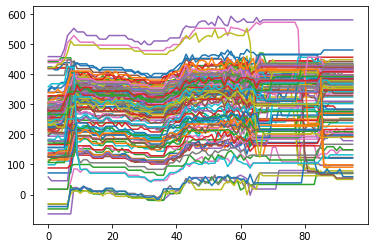

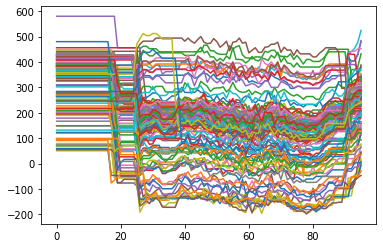

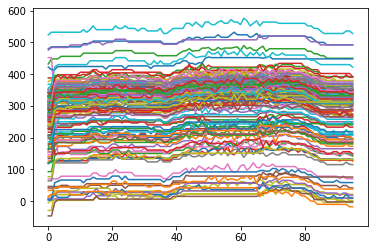

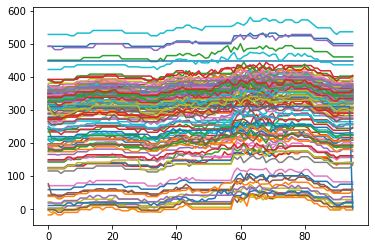

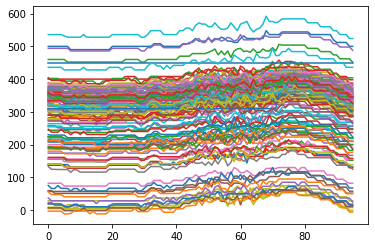

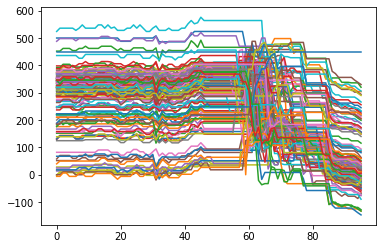

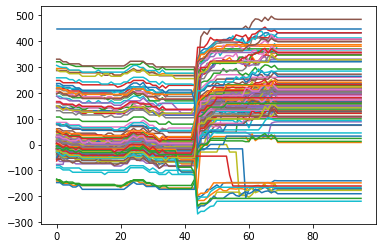

In [67]:
# 画图
# Wspd, Wdir, Etmp, Itmp, Prtv, Pab1-3, Ndir
column = 'Ndir'
li = list(range(134))
plot_patv(data, column, li)

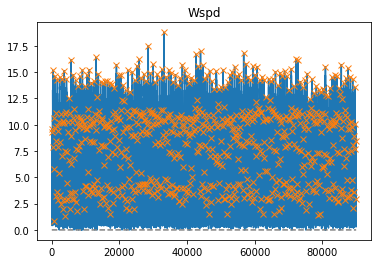

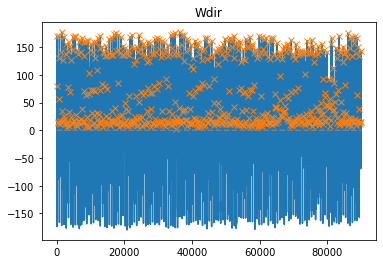

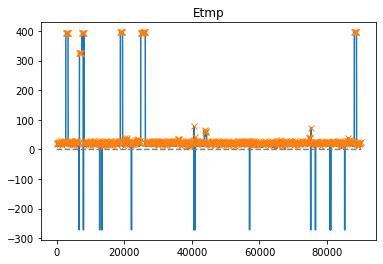

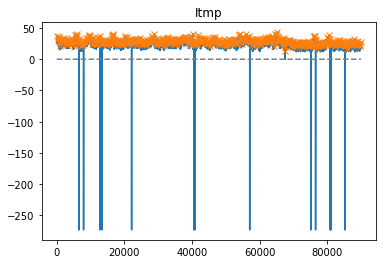

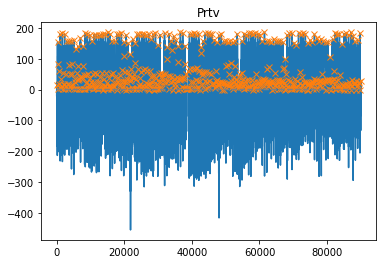

In [66]:
li = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Prtv']
peak_list = raw_data_peak(data, li, distance=100)

In [18]:
# 调用

data = tmp_anomaly_replace(data)

data = get_time_week(data)
# data = raw_extract(data, 'TurbID', 'time_week')
data = filtered_extract(data, 'TurbID', 'time_week')

Feature Extraction: 100%|██████████| 99/99 [02:42<00:00,  1.64s/it]


In [77]:
data = get_time_hour(data)

In [78]:
data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,time_hour
0,1,1,00:00,2.81,-2.00,16.61,30.95,148.0,0.03,0.03,0.03,-19.38,111.13,0
1,1,1,00:15,2.48,-4.30,16.38,30.83,148.0,0.03,0.03,0.03,-15.69,75.30,0
2,1,1,00:30,1.16,9.28,16.62,31.05,135.0,0.03,0.03,0.03,-2.50,9.54,0
3,1,1,00:45,0.92,14.38,16.13,31.20,148.0,0.04,0.04,0.03,-0.70,0.00,0
4,1,1,01:00,1.38,-4.28,15.12,29.52,148.0,89.68,89.69,89.50,-0.30,0.00,1


In [20]:
feat_columns = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Prtv']
li = list(range(10))
data = lag_feature(data, feat_columns, li)
data = unique_avg(data, feat_columns)

In [79]:
train_feat, train_label, test_feat, test_label, test_individual_feat, test_individual_label = dataset_split(data)

In [80]:
# gbm = lgb_cv(train_feat, train_label, test_feat, test_label)
gbm = lgb(train_feat, train_label, test_feat, test_label)

TypeError: 'module' object is not callable

The rmse of prediction is: 76.92050386459636
The mse of prediction is: 5916.763914783383
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 

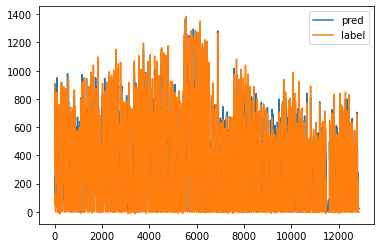

In [23]:
lgb_test(gbm, test_feat)

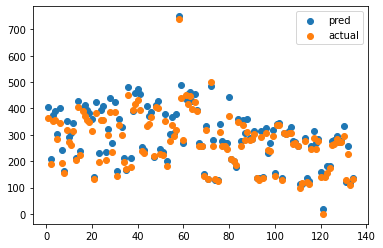

In [24]:
avg_compare(test_individual_feat, test_individual_label, gbm)

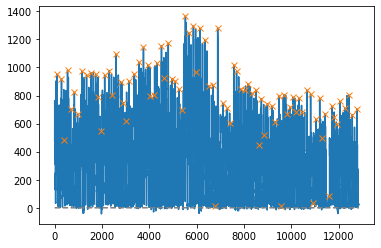

In [64]:
pred_peak_list = pred_peak(gbm.predict(test_feat), distance=100)